In [1]:
import imageio as iio
import numpy as np
import pandas as pd
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image as im
import os
from glob import glob
import csv
import imageio as iio
import cv2
# importing matplotlib modules
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image as im
from PIL import ImageFilter
from mtcnn import MTCNN
from keras.preprocessing.image import ImageDataGenerator
from ultralytics import YOLO

c:\Users\akars\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\akars\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\akars\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\akars\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

Eye Detection

In [2]:
def eye_detection(cow_id):
    max_pix = []
    min_pix = []
    mean_pix = []
    image_num = 0
    kernel = np.ones((7,7),np.uint8)
    kernel1 = np.ones((9,9),np.uint8)

    directory_path = cow_id +"/dataset_features_/"
    # Loop over all the images
    for filename in os.listdir(cow_id):
        # Load image
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(cow_id, filename))
            temp = cv2.imread(os.path.join(cow_id, filename))
        

            #image = im.fromarray(img)
            max_pix.append(img.max())
            min_pix.append(img.min())
            mean_pix.append(img.mean())

            if not os.path.exists(directory_path):
                os.makedirs(directory_path)
            
            cv2.imwrite( directory_path +filename+'_'+'main'+'.jpg', img )
            
            img[img<230] = 0
            #cv2.imwrite( "dataset/"+str(image_num)+'_'+'threshold'+'.jpg', img )
            
            
            img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
            img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel1)
            #img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel1)
            
            #cv2.imwrite( "dataset/"+str(image_num)+'_'+'opening'+'.jpg', img )
            
            thresh = 1
            im_bw = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)[1]
            
            cv2.imwrite( directory_path+filename+'_'+'mask'+'.jpg', im_bw )
            
            result = cv2.bitwise_and(temp, im_bw)
            cv2.imwrite( directory_path+filename+'_'+'eye'+'.jpg', result )
            
            image = im.fromarray(img)

            image1 = image.filter(ImageFilter.FIND_EDGES)
            
            #cv2.imwrite( "dataset/"+str(image_num)+'_'+'mask'+'.jpg', image1 )
            
            image_num +=1

Bounding Boxes (Object Detection)

* Use object detection, yolov8 pretrained model, to detect the bounding boxes to capture the cow's face in the image.

In [3]:


def cow_detection(image_path):
    model = YOLO("yolov8m.pt")
    results = model.predict(image_path)
    result = results[0]
    box = result.boxes[0]
    cords = box.xyxy[0].tolist()
    cords = [round(x) for x in cords]
    class_id = result.names[box.cls[0].item()]
    conf = round(box.conf[0].item(), 2)
    return cords
    # print("Object type:", class_id)
    # print("Coordinates:", cords)
    # print("Probability:", conf)

def draw_bounding_box(image_path, x1, y1, x2, y2, output_path1, output_path2):
    # Load the image
    image = cv2.imread(image_path)

    # Draw the bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Extract the image in the bounding box
    roi = image[y1:y2, x1:x2]
    cv2.imwrite(output_path2, roi)

    # Display the image
    cv2.imwrite(output_path1, image)
    
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

In [4]:
def object_detection(cow_id):
    
    # Get a list of file names in the directory
    file_names = os.listdir(cow_id+"/dataset_features_/")
    out_dir = cow_id+"/dataset_features_/bounding_boxes/"
    # Sort the list of file names alphabetically
    data = {}

    # Loop over all the images
    for filename in file_names:
        
        # Load image
        if filename.endswith("main.jpg") :
            try:
                image_path = os.path.join(cow_id+"/dataset_features_", filename)
                cords = cow_detection(image_path)
             
                if not os.path.exists(out_dir):
                    os.makedirs(out_dir)
                out1 = out_dir + filename + "green_box" +".jpg"
                out2 = out_dir + filename + "bounding_box" + ".jpg"
                draw_bounding_box(image_path, *cords, out1, out2)
            except:
                print("Error in image {}".format(filename))
                continue
        
        

Cow Edge/Profile Detection

* Further narrow down the region of interest to the cow's profile to get a fine edge detection and get rid of all the background

In [5]:
def cow_profile_detection(cow_id):
    
    kernel = np.ones((7,7),np.uint8)
    kernel1 = np.ones((9,9),np.uint8)
    dir = cow_id + "/dataset_features_/bounding_boxes/"
    out_dir = cow_id + "/dataset_features_/profile/"
    # Loop over all the images
    for filename in os.listdir(dir):
        # Load image
        if filename.endswith("bounding_box.jpg"):
            img = cv2.imread(os.path.join(dir, filename))
            # get the filename before
            file_name = os.path.basename(filename).split('.jpg')[0]

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Use contours to detect the highest temperature area
            # threshold = 200 captures high temperature areas, threshold = 100 captures entire cow
            ret, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            max_area = 0
            best_contour = None

            for contour in contours:
                area = cv2.contourArea(contour)
                if area > max_area:
                    max_area = area
                    best_contour = contour

            cv2.drawContours(img, [best_contour], -1, (0, 255, 0), 3)

            x, y, w, h = cv2.boundingRect(best_contour)
            high_temp = img[y:y+h, x:x+w]
            
            # Create a new image with a black background
            new_img = np.zeros(img.shape, dtype=np.uint8)
            duplicate_img = img.copy()
            # Draw the contour on the new image in white color
            cv2.drawContours(new_img, [best_contour], -1, (255, 255, 255), -1)
            # Draw the contour on the duplicate image in red color
            cv2.drawContours(duplicate_img, [best_contour], -1, (0, 0, 255), 3)


            # Display the result
            # cv2.imshow('Cow with detected eyes and nose', duplicate_img)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
                
            out1 = out_dir+file_name+"_cow_edge.jpg"
            out2 = out_dir+file_name+"_cow_edge_contour.jpg"
            cv2.imwrite(out1, new_img)
            cv2.imwrite(out2, duplicate_img)
    
            

High temperature detection
* Detect high temperature regions in the image

In [6]:
def high_temp_detection(cow_id):
    i = 0
    kernel = np.ones((7,7),np.uint8)
    kernel1 = np.ones((9,9),np.uint8)
    dir = cow_id + "/dataset_features_/profile/"
    output_folder = cow_id + "/dataset_features_/features/"

    # Loop over all the images
    for filename in os.listdir(dir):
        # Load image
        try:
            if filename.endswith("contour.jpg"):
                img = cv2.imread(os.path.join(dir, filename))
                file_name = os.path.basename(filename).split('.jpg')[0]

                # Convert to grayscale
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Use contours to detect the highest temperature area
                # threshold = 200 captures high temperature areas, threshold = 100 captures entire cow
                ret, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
                contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                if len(contours) == 0:
                    print("No contour found")
                    continue

                max_area = 0
                best_contour = None

                for contour in contours:
                    area = cv2.contourArea(contour)
                    if area > max_area:
                        max_area = area
                        best_contour = contour

                cv2.drawContours(img, [best_contour], -1, (0, 255, 0), 3)

                x, y, w, h = cv2.boundingRect(best_contour)
                high_temp = img[y:y+h, x:x+w]
                
                # Create a new image with a black background
                new_img = np.zeros(img.shape, dtype=np.uint8)
                duplicate_img = img.copy()
                # Draw the contour on the new image in white color
                cv2.drawContours(new_img, [best_contour], -1, (255, 255, 255), -1)
                # Draw the contour on the duplicate image in red color
                cv2.drawContours(duplicate_img, [best_contour], -1, (0, 0, 255), 3)


                # Display the result
                # cv2.imshow('Cow with detected eyes and nose', new_img)
                # cv2.waitKey(0)
                # cv2.destroyAllWindows()

                if not os.path.exists(output_folder):
                    os.makedirs(output_folder)

                out1 = output_folder + file_name + "_high_temp_region.jpg"
                out2 = output_folder + file_name + "_high_temp_region_outline.jpg"
                cv2.imwrite(out1, new_img)
                cv2.imwrite(out2, duplicate_img)
                i = i+1
        except:
            print("Error: ", filename)
            continue
            

Convert images to Thermal images and Infra Red images

In [7]:
def convert_to_irt(cow_id):
    dir = cow_id + "/dataset_features_/profile/"
    # Path to the folder where the infrared images will be stored
    output_folder = cow_id + "/dataset_features_/infrared/"

    # Loop over the images in the folder
    for filename in os.listdir(dir):
        if filename.endswith("contour.jpg"):
            # Load the image
            image = cv2.imread(os.path.join(dir, filename))
            file_name = os.path.basename(filename).split('cow')[0]
            
            # Convert to grayscale
            grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply a color map to convert to infrared-like visualization
            thermal_image = cv2.applyColorMap(grayscale_image, cv2.COLORMAP_JET)
            
            # Generate output image filename
            output_filename = f"{os.path.splitext(file_name)[0]}_infrared.jpg"
            
            # Create output folder if it doesn't exist
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            
            # Save the infrared image
            output_path = os.path.join(output_folder, output_filename)
            cv2.imwrite(output_path, thermal_image)

In [8]:
def high_temp_irt(cow_id):
    dir = cow_id + "/dataset_features_/infrared/"

    # Path to the folder where the infrared images will be stored
    output_folder = cow_id + "/dataset_features_/high_temp_thermal/"

    # Loop over the images in the folder
    for filename in os.listdir(dir):
        if filename.endswith(".jpg"):
            file_name = os.path.basename(filename).split('infrared')[0]
            # Load the image
            thermal_image = cv2.imread(os.path.join(dir, filename))

            # Convert the image to the HSV color space
            hsv_image = cv2.cvtColor(thermal_image, cv2.COLOR_BGR2HSV)

            # Define the lower and upper thresholds for the red color range
            # lower_red = np.array([0, 50, 50])  # Adjust the values as needed
            # upper_red = np.array([10, 255, 255])  # Adjust the values as needed
            # Get the image dimensions
            height, width = hsv_image.shape[:2]

            # Calculate the region of interest (ROI) coordinates for the lower third
            roi_start_y = int(height * 4 / 5)  # Starting y-coordinate of the ROI
            roi_end_y = height  # Ending y-coordinate of the ROI

            roi_start_x = 0  # Starting x-coordinate of the ROI
            roi_end_x = int(height * 1 / 3) # Ending x-coordinate of the ROI

            # Crop the image to retain only the lower third
            cropped_image = hsv_image[roi_start_y:roi_end_y, :]
            cropped_image = cropped_image[:, roi_start_x:roi_end_x]

            # Define the lower and upper thresholds for the red color range
            lower_red = np.array([0, 100, 100])  # Adjust the values as needed
            upper_red = np.array([10, 255, 255])  # Adjust the values as needed

            # Create a mask for the red regions based on the defined thresholds
            red_mask = cv2.inRange(hsv_image, lower_red, upper_red)

            # Apply the mask to the thermal image to extract the red regions
            red_regions = cv2.bitwise_and(thermal_image, thermal_image, mask=red_mask)

            # Generate output image filename
            output_filename = f"{os.path.splitext(file_name)[0]}_nose.jpg"
            output_filename2 = f"{os.path.splitext(file_name)[0]}_nose_contour.jpg"
            output_filename3 = f"{os.path.splitext(file_name)[0]}_thermal.jpg"
            
            # Create output folder if it doesn't exist
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            
            # Save the infrared image
            output_path = os.path.join(output_folder, output_filename)
            output_path2 = os.path.join(output_folder, output_filename2)
            output_path3 = os.path.join(output_folder, output_filename3)
            # cv2.imwrite(output_path, only_cow_img)
            # cv2.imwrite(output_path2, new_img)
            cv2.imwrite(output_path3, red_regions)


Nose Detection on the thermal images
* Detect the nose of the cow given the thermal image of the cow

In [9]:
def nose_detection(cow_id):
    dir = cow_id + "/dataset_features_/high_temp_thermal/"

    # Path to the folder where the infrared images will be stored
    output_folder = cow_id + "/dataset_features_/noses/"
    noses_df = pd.DataFrame(columns=['cow_id', 'cow', 'nose_img_path', 'x', 'y', 'w', 'h'])
    # Loop over the images in the folder
    for filename in os.listdir(dir):
        if filename.endswith(".jpg"):
            # Load the image
            image = cv2.imread(os.path.join(dir, filename))
            file_name = os.path.basename(filename).split('thermal')[0]
            # Convert the image to the HSV color space
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

            # Define the lower and upper thresholds for red color in HSV
            lower_red = np.array([0, 100, 100])
            upper_red = np.array([10, 255, 255])

            # Create a binary mask of the red color range
            mask = cv2.inRange(hsv, lower_red, upper_red)

            # Specify the region of interest (bottom left corner)
            height, width = mask.shape[:2]
            roi = mask[int(0.75 * height):height, 0:int(0.75 * width)]

            # Apply morphological operations (optional) to refine the mask
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            roi = cv2.morphologyEx(roi, cv2.MORPH_OPEN, kernel)

            # Find contours in the ROI
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Sort the contours by their area in descending order
            sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

            # Find the bounding rectangle for the first red portion in the ROI
            if len(sorted_contours) > 0:
                x, y, w, h = cv2.boundingRect(sorted_contours[0])

                # Adjust the coordinates to the original image space
                x += 0  # Offset in X direction
                y += int(0.75 * height)  # Offset in Y direction

                # add to dataframe
                noses_df = noses_df.append({'cow_id': cow_id, 'cow': file_name, 'nose_img_path': os.path.join(output_folder, file_name + "_nose.jpg"), 'x': x, 'y': y, 'w': w, 'h': h}, ignore_index=True)
                # Draw the bounding rectangle on the original image
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # Crop the bounding rectangle from the original image
                nose_img = image[y:y + h, x:x + w]

            # Generate output image filename
            output_filename = f"{os.path.splitext(file_name)[0]}_nose_bounding_box.jpg"
            output_filename2 = f"{os.path.splitext(file_name)[0]}_nose.jpg"

            # Create output folder if it doesn't exist
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            # Save the infrared image
            output_path = os.path.join(output_folder, output_filename)
            output_path2 = os.path.join(output_folder, output_filename2)
            
            try:
                cv2.imwrite(output_path, image)
                cv2.imwrite(output_path2, nose_img)
            except:
                print("error")
                continue

    noses_df.to_csv(cow_id + "/dataset_features_/noses/nose_coord.csv", index=False)
            

In [10]:
def nose_detection_map(cow_id):
    dir = cow_id + "/dataset_features_/profile/"
    output_folder = cow_id + "/dataset_features_/original_noses/"
    noses_df = pd.read_csv(cow_id + "/dataset_features_/noses/nose_coord.csv")

    # Loop over the images in the folder
    for filename in os.listdir(dir):
        if filename.endswith("contour.jpg"):
            # Load the image
            image = cv2.imread(os.path.join(dir, filename))
            file_name = os.path.basename(filename).split('cow')[0] + "__"

            # Create output folder if it doesn't exist
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            # Get the nose coordinates
            nose = noses_df.loc[noses_df['cow'] == file_name]
            
            # if not an empty dataframe
            if not nose.empty:
                # draw the bounding box over the detected nose
                cv2.rectangle(image, (nose['x'].values[0], nose['y'].values[0]), (nose['x'].values[0]+nose['w'].values[0], nose['y'].values[0]+nose['h'].values[0]), (0, 255, 0), 2)

                # Crop the image
                crop_img = image[nose['y'].values[0]:nose['y'].values[0]+nose['h'].values[0], nose['x'].values[0]:nose['x'].values[0]+nose['w'].values[0]]
                
                # Display the image
                # cv2.imshow("Image", image)
                # cv2.imshow("Cropped", crop_img)
                # cv2.waitKey(0)
                # cv2.destroyAllWindows()
                
                # Save the image
                output_filename = f"{os.path.splitext(file_name)[0]}_nose.jpg"
                output_filename_crop = f"{os.path.splitext(file_name)[0]}_nose_crop.jpg"

                output_path = os.path.join(output_folder, output_filename)
                output_path_crop = os.path.join(output_folder, output_filename_crop)

                cv2.imwrite(output_path, image)
                cv2.imwrite(output_path_crop, crop_img)
            else:
                print(f"Could not find nose coordinates for {file_name}")
                continue



Nostrils Detection
* Detect the nostrils of the cow given the noses

In [11]:
def nostril_detection(cow_id):    
    dir = cow_id + "/dataset_features_/original_noses/"
    output_folder = cow_id + "/dataset_features_/nostrils/"

    # Loop over the images in the folder
    for filename in os.listdir(dir):
        if filename.endswith("crop.jpg"):
            # Read the image
            image = cv2.imread(os.path.join(dir, filename))
            file_name = os.path.basename(filename).split('nose')[0] + "__"
            
            # Create output folder if it doesn't exist
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            # Convert the image to grayscale
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply median blur to reduce noise
            gray_image = cv2.medianBlur(gray_image, 5)

            # Apply adaptive thresholding using mean-based method
            th = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

            # Save the image
            output_filename = f"{os.path.splitext(file_name)[0]}_nostrils.jpg"

            output_path = os.path.join(output_folder, output_filename)
            # Save the image with bounding boxes
            cv2.imwrite(output_path, th)

Calculate the distance between nostrils to estimate breathing rate

In [12]:
def distance_area_nostrils(cow_id):
    dir = cow_id + "/dataset_features_/nostrils/"
    df = pd.DataFrame(columns=['cow_id_timestamp', 'distance_bw_nostrils', 'total_area_nostrils'])

    for filename in os.listdir(dir):
        try:
            if filename.endswith(".jpg"):
                # Load the image
                image = cv2.imread(os.path.join(dir,filename), cv2.IMREAD_GRAYSCALE)
                filename = os.path.basename(filename).split('nose')[0]
                
                # Define the cropping margins
                crop_margin = 4  # Margin to crop out

                # Crop the image to exclude the borders
                cropped_image = image[crop_margin:-crop_margin, crop_margin:-crop_margin]

                # Apply thresholding to create a binary image
                ret, thresholded = cv2.threshold(cropped_image, 128, 255, cv2.THRESH_BINARY)

                # Apply morphological closing to fill gaps and connect nearby pixels
                kernel = np.ones((2, 2), np.uint8)
                closed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)
                opening = cv2.morphologyEx(closed, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))


                # Remove small contours
                contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                for i, c in enumerate(contours):
                    area_tresh = 10  # Adjust this value based on your image
                    area = cv2.contourArea(c)
                    if area < area_tresh:  # Fill small contours with black color
                        cv2.drawContours(opening, contours, i, 0, cv2.FILLED)

                # images = [cropped_image,  thresholded, closed, opening]
                # titles = ['Original Image','BINARY','Closed','Opening']
                # # plot the images
                # for i in range(4):
                #     plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
                #     plt.title(titles[i])
                #     plt.xticks([]),plt.yticks([])
                # plt.show()


                contours, hierarchy = cv2.findContours(255 - opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                #print("Number of contours:", len(contours))

                # get the 2 largest contours
                if len(contours) >= 2:
                    c1, c2 = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
                    black_patches = [c1, c2]

                    # if cv2.moments(c1)['m00'] == 0 or cv2.moments(c2)['m00'] == 0:
                    #     continue
                    
                    # Calculate the rightmost pixel of the left black contour
                    left_contour = black_patches[0] if black_patches[0][0, 0, 0] < black_patches[1][0, 0, 0] else black_patches[1]
                    rightmost_left_pixel = left_contour[left_contour[:, :, 0].argmax()]

                    # Calculate the leftmost pixel of the right black contour
                    right_contour = black_patches[1] if black_patches[0][0, 0, 0] < black_patches[1][0, 0, 0] else black_patches[0]
                    leftmost_right_pixel = right_contour[right_contour[:, :, 0].argmin()]

                    # Calculate the distance between the two pixels
                    distance = np.linalg.norm(rightmost_left_pixel - leftmost_right_pixel)

                    # Calculate the area of the black patches
                    area = cv2.contourArea(c1) + cv2.contourArea(c2)

                    # # Calculate centroids of the black patches
                    # centroids = [cv2.moments(cnt)['m01'] / cv2.moments(cnt)['m00'] for cnt in black_patches]

                    # # Calculate the distance between centroids
                    # distance = abs(centroids[0] - centroids[1])
                    df = df.append({'cow_id_timestamp': filename, 'distance_bw_nostrils': distance, 'total_area_nostrils': area}, ignore_index=True)
                    

        except:
            continue
    
    df.to_csv(cow_id + "/dataset_features_/nostrils/distance_area_nostrils.csv", index=False)

            # out_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to BGR before drawing colored contour.

            # cv2.drawContours(out_img, [approx], 0, (0, 255, 0), 3)
            # cv2.drawContours(out_img, [approx2], 0, (0, 255, 0), 3)
            # cv2.imshow("Result", out_img)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()


In [13]:
def remove_outliers(cow_id):
    df = pd.read_csv(cow_id + "/dataset_features_/nostrils/distance_area_nostrils.csv")
    # Calculate the mean of the distance between nostrils
    mean = df['distance_bw_nostrils'].mean()
    # Calculate the standard deviation of the distance between nostrils
    std = df['distance_bw_nostrils'].std()
    
    # Calculate the median
    median = df['distance_bw_nostrils'].median()

    # Calculate the upper threshold
    upper_threshold = median + 0.3*std
    # Filter out the outliers
    df = df[(df['distance_bw_nostrils'] < upper_threshold)]

    df.to_csv(cow_id + "/dataset_features_/nostrils/distance_area_nostrils_filtered.csv", index=False)

In [14]:
from datetime import datetime

def convert_to_datetime(date_parts):
    year = int(date_parts[0])
    month = date_parts[1]
    day = int(date_parts[2])
    hour = int(date_parts[3])
    minute = int(date_parts[4])
    second = int(date_parts[5])
    millisec = int(date_parts[6])
    
    month_num = datetime.strptime(month, '%b').month
    
    dt = datetime(year, month_num, day, hour, minute, second, millisec * 1000)
    return dt


def plot_breathing(cow_id):
    df = pd.read_csv(cow_id + "/dataset_features_/nostrils/distance_area_nostrils.csv")

    # Get the words after the last alphabet in the string
    time_stamp = df['cow_id_timestamp'].str.split('nostrils').str[0]
    time_stamp = time_stamp.str.split('___').str[0]

    # get rid of the last number from the end of the string
    time_stamp = time_stamp.str.split('_').str[:-1]
    time_stamp = time_stamp[1:]

    # convert pandas series to array
    time_stamp = time_stamp.to_numpy()

    # convert numpy array to normal array
    time_stamp = time_stamp.tolist()

    # get rid of the first entry in each array
    time_stamp = [x[1:] for x in time_stamp]
    
    # convert the array to a datetime object
    for t in time_stamp:
        t = convert_to_datetime(t)
        df['cow_id_timestamp'] = t
    

    # Convert 'cow_id_timestamp' to datetime
    df['cow_id_timestamp'] = pd.to_datetime(df['cow_id_timestamp'])

    # Extract minute, second, and millisecond components
    df['minute_second_millisecond'] = df['cow_id_timestamp'].dt.strftime('%M:%S.%f')[:-3]
    print(df['minute_second_millisecond'])
    print(df['cow_id_timestamp'])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df['minute_second_millisecond'], df['distance_bw_nostrils'], marker='o')
    plt.xlabel('Time (minute:second.millisecond)')
    plt.ylabel('Distance between Nostrils')
    plt.title('Distance between Nostrils vs Time')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    plt.show()





    # get rid of the last number from the end of the string
    


    
    

In [19]:
def plot2(cow_id):
    df = pd.read_csv(cow_id + "/dataset_features_/nostrils/distance_area_nostrils.csv")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df['distance_bw_nostrils'], marker='o')
    plt.xlabel('Cow ID Timestamp')
    plt.ylabel('Distance between Nostrils')
    plt.title('Distance between Nostrils vs Cow ID Timestamp')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    plt.show()

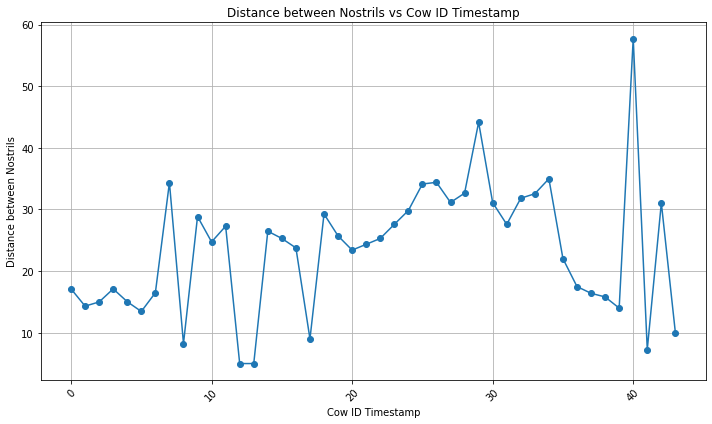

In [24]:
cow_id = "124000189436861"
# eye_detection(cow_id)
# object_detection(cow_id)
# cow_profile_detection(cow_id)
# high_temp_detection(cow_id)
# convert_to_irt(cow_id)
# high_temp_irt(cow_id)
# nose_detection(cow_id)
# nose_detection_map(cow_id)
# nostril_detection(cow_id)
#distance_area_nostrils(cow_id)
#remove_outliers(cow_id)
plot2(cow_id)

# Further analysis


In [6]:
dir = "noses/"

# Path to the folder where the infrared images will be stored
output_folder = "noses_inf"

# Loop over the images in the folder
for filename in os.listdir(dir):
    if filename.endswith(".jpg"):
        # Load the image
        image = cv2.imread(os.path.join(dir, filename))

        # Convert the image to the HSV color space
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Define the lower and upper thresholds for yellow color in HSV
        lower_red = np.array([20, 100, 100])
        upper_red = np.array([40, 255, 255])

        # Create a binary mask of the red color range
        mask = cv2.inRange(hsv, lower_red, upper_red)

        # Specify the region of interest (bottom left corner)
        height, width = mask.shape[:2]
        roi = mask[int(0.75 * height):height, 0:int(0.75 * width)]

        # Apply morphological operations (optional) to refine the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        roi = cv2.morphologyEx(roi, cv2.MORPH_OPEN, kernel)

        # Find contours in the ROI
        contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Sort the contours by their area in descending order
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

        # Find the bounding rectangle for the first red portion in the ROI
        if len(sorted_contours) > 0:
            x, y, w, h = cv2.boundingRect(sorted_contours[0])

            # Adjust the coordinates to the original image space
            x += 0  # Offset in X direction
            y += int(0.75 * height)  # Offset in Y direction

            # Draw the bounding rectangle on the original image
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Crop the bounding rectangle from the original image
            nose_img = image[y:y + h, x:x + w]

        # Generate output image filename
        output_filename = f"{os.path.splitext(filename)[0]}_nose_bounding_box.jpg"
        output_filename2 = f"{os.path.splitext(filename)[0]}_nose.jpg"

        # Create output folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Save the infrared image
        output_path = os.path.join(output_folder, output_filename)
        output_path2 = os.path.join(output_folder, output_filename2)
        
        try:
            cv2.imwrite(output_path, image)
            cv2.imwrite(output_path2, nose_img)
        except:
            print("error")
            continue

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

Nose Detection in Profile View

Nose detection on labeled images (using VGG Annotator)

In [23]:

def extract_portion_within_bounding_box(image_name, x1, y1, x2, y2, output_path):

    dir = "feat"
    dir_out = "noses/profile/"
    # Path to the folder where the images will be stored
    output_filename = f"{os.path.splitext(image_name)[0]}_nose.jpg"
    output_folder = os.path.join(dir_out, output_filename)

    # Loop over the images in the folder
    for filename in os.listdir(dir):
        if filename.endswith(image_name):
            
            # Load the image
            image = cv2.imread(os.path.join(dir, filename))

            # Convert the image to black and white
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Draw the yellow bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 2)

            # Extract the portion within the bounding box
            portion = image[y2:y1, x1:x2]

            # Save the extracted portion as a new image
            cv2.imwrite(output_folder, portion)

        #print(f"Portion within the bounding box saved to: {output_path}")

dir = "noses/profile/"
# read a csv file in the dir
df = pd.read_csv("noses/profile/bounding_boxes.csv")

for row in df.itertuples():
    image = row.filename
    output_path = dir
    region = row.region_shape_attributes
    #convert region to a dictionary
    region_dict = dict(eval(region))
    x1 = region_dict['x']
    x2 = region_dict['x'] + region_dict['width']
    y1 = region_dict['y']
    y2 = region_dict['y'] - region_dict['height']
    extract_portion_within_bounding_box(image, x1, y1, x2, y2, output_path)



(278, 255)
2 231 60 185
(282, 251)
2 231 60 185
(281, 254)
2 233 60 189
(278, 253)
2 233 60 189
(473, 432)
2 235 60 196
(278, 253)
2 235 60 196
(247, 80)
1 221 58 178
(264, 245)
1 221 58 178
(273, 250)
2 233 59 193
(276, 255)
2 233 59 193
(472, 404)
1 227 59 180
(277, 254)
1 227 59 180
(466, 400)
1 228 59 183
(275, 248)
1 228 59 183
(271, 221)
1 230 61 187
(274, 247)
1 230 61 187
(481, 402)
1 241 53 202
(282, 251)
1 241 53 202
(282, 226)
2 234 59 191
(283, 249)
2 239 62 202
(260, 215)
2 235 58 191
(283, 253)
2 235 58 191
(281, 255)
2 235 58 191
(247, 80)
2 235 58 191
(273, 249)
2 235 58 191
(484, 406)
2 235 58 191
(281, 252)
2 235 58 191
(272, 218)
2 235 58 191
(217, 213)
2 235 58 191
(265, 215)
2 235 58 191
(474, 407)
2 235 58 191
(264, 245)
2 235 58 191
(509, 309)
2 235 58 191
(280, 256)
2 235 58 191
(275, 250)
2 235 58 191
(275, 248)
2 235 58 191
(475, 403)
2 235 58 191
(211, 212)
2 235 58 191
(215, 212)
2 235 58 191


Train ML Algo for Nose Detection on other images

Data Augmentation

In [11]:
def apply_data_augmentation(image):
    # Flip the image horizontally (left to right)
    flipped_image = cv2.flip(image, 1)

    # Rotate the image by a specified angle (e.g., 45 degrees)
    rotation_angle = 45
    rows, cols, _ = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))

    # Add Gaussian noise to the image
    mean = 0
    std_dev = 0.1
    noisy_image = image + np.random.normal(mean, std_dev, image.shape)

    # Scale the image (e.g., zoom in)
    scale_factor = 1.2
    scaled_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)

    # Return the augmented images
    return [flipped_image, rotated_image, noisy_image, scaled_image]

dir = "noses/profile/"
output_folder = "noses/profile/augmented/"
# Loop over the images in the folder
for filename in os.listdir(dir):
    if filename.endswith("cow.jpg"):
        # Load the image
        image = cv2.imread(os.path.join(dir, filename))

        # Perform data augmentation
        augmented_images = apply_data_augmentation(image)

        # Save the augmented images
        for i, aug_img in enumerate(augmented_images):
            output_filename = f"{os.path.splitext(filename)[0]}_augmented_image_{i}.jpg"
            output_path = os.path.join(output_folder, output_filename)
            cv2.imwrite(output_path, aug_img)


In [12]:

def augment_images_in_folder(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Create an ImageDataGenerator object with augmentation options
    data_gen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Loop through each image file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Load the image using OpenCV
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)

            # Convert image to RGB format (Keras ImageDataGenerator expects RGB images)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Convert single image to batch format (add a batch dimension)
            image = image.reshape((1, *image.shape))

            # Apply data augmentation to the image
            augmented_images = data_gen.flow(image, batch_size=1)
            

            # Save the augmented images with appropriate filenames
            for i, aug_img in enumerate(augmented_images):
                output_filename = f"{os.path.splitext(filename)[0]}_augmented_{i}.jpg"
                output_path = os.path.join(output_folder, output_filename)
                cv2.imwrite(output_path, cv2.cvtColor(aug_img[0], cv2.COLOR_RGB2BGR))
                if i == 4:  # Save 5 augmented images for each input image
                    break

# Specify the input and output folders
input_folder_path = 'noses/profile'
output_folder_path = 'noses/profile/augmented2'

# Call the function to augment images in the input folder and save to the output folder
augment_images_in_folder(input_folder_path, output_folder_path)


Semantic Segmentation

In [19]:
import os
import cv2
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd
import joblib

# Step 1: Load the VGG16 model with pre-trained weights from ImageNet
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Preprocess the input images to match the format required by VGG16
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Step 3: Extract features from VGG16 for each image in the dataset
def extract_vgg_features(images):
    vgg_features = vgg_model.predict(images)
    vgg_features = vgg_features.reshape(vgg_features.shape[0], -1)
    return vgg_features

# Step 4: Prepare ground truth labels for semantic segmentation
def prepare_ground_truth_masks(mask_file_paths):
    mask_images = []
    for mask_path in mask_file_paths:
        mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_images.append(mask_image)

    return np.array(mask_images)

# Step 5: Train a Random Forest classifier using the extracted VGG16 features and ground truth labels
def train_random_forest(features, labels):
    # # Check for and handle missing values in features and labels
    # imputer = SimpleImputer(strategy='mean')
    # features = imputer.fit_transform(features)
    # labels = imputer.fit_transform(labels)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    accuracy = rf_classifier.score(X_test, y_test)
    return rf_classifier, accuracy

# Step 6: Perform semantic segmentation on new images using the trained Random Forest classifier
def semantic_segmentation(image_path, rf_classifier):
    image = preprocess_image(image_path)
    vgg_features = extract_vgg_features(image)
    predicted_label = rf_classifier.predict(vgg_features)
    # Post-processing and visualization (not implemented here)
    # For semantic segmentation, predicted_label should be converted to masks
    return predicted_label

# Function to save trained models to disk
def save_models(rf_classifier, model_weights_path, rf_model_path):
    vgg_model.save_weights(model_weights_path)
    joblib.dump(rf_classifier, rf_model_path)

# Function to read image file paths and ground truth mask file paths from Excel file
def read_data_from_excel(excel_file_path):
    data_df = pd.read_excel(excel_file_path)
    image_file_paths = data_df['ImagePath'].tolist()
    mask_file_paths = data_df['LabelledImagePath'].tolist()
    return image_file_paths, mask_file_paths

# Example usage:
excel_file_path = 'hmm.xlsx'
input_folder_path = 'noses/profile/augmented'

# Read image file paths and ground truth mask file paths from Excel file
image_file_paths, mask_file_paths = read_data_from_excel(excel_file_path)

# Prepare VGG16 features and ground truth masks for training
vgg_features_list = []
for image_path in image_file_paths:
    image = preprocess_image(image_path)
    vgg_features = extract_vgg_features(image)
    vgg_features_list.append(vgg_features)

ground_truth_masks = prepare_ground_truth_masks(mask_file_paths)

# Concatenate the features and ground truth masks
vgg_features = np.concatenate(vgg_features_list, axis=0)

# Train the Random Forest classifier on multiple images and masks
trained_rf_classifier, accuracy = train_random_forest(vgg_features, ground_truth_masks)

# Save the trained models to disk
model_weights_path = 'vgg16_model_weights.h5'
rf_model_path = 'random_forest_model.joblib'
save_models(trained_rf_classifier, model_weights_path, rf_model_path)

# Now you can use the saved models to perform semantic segmentation on new images:
# Load the VGG16 model with pre-trained weights
loaded_vgg_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
loaded_vgg_model.load_weights(model_weights_path)

# Load the trained Random Forest classifier
loaded_rf_classifier = joblib.load(rf_model_path)

# Perform semantic segmentation on new images
new_image_path = 'noses/profile/34_cow.jpg'
predicted_mask = semantic_segmentation(new_image_path, loaded_rf_classifier)
# Display the predicted mask
cv2.imshow('predicted_mask', predicted_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


c:\Users\akars\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


AttributeError: 'bool' object has no attribute 'any'

In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def preprocess_data(image_path, bbox_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    bbox_image = load_img(bbox_path, target_size=target_size)
    bbox_image = img_to_array(bbox_image)

    bbox_image = cv2.imread(bbox_path)
    bbox_mask = cv2.inRange(bbox_image, (0, 255, 255), (0, 255, 255))  # Yellow color range
    bbox_mask = bbox_mask[:, :, np.newaxis]
    bbox_mask = np.where(bbox_mask > 0, 1, 0)  # Convert mask to binary (0 or 1)
    return image, bbox_image

# Load and preprocess the data from CSV file
def load_data(csv_file_path, image_folder, bbox_folder):
    data_df = pd.read_csv(csv_file_path)
    images = []
    bbox_masks = []
    for index, row in data_df.iterrows():
        image_path = row['ImagePath']
        bbox_path = row['LabelledImagePath']
        image, bbox_mask = preprocess_data(image_path, bbox_path)
        images.append(image)
        bbox_masks.append(bbox_mask)

    return np.array(images), np.array(bbox_masks)

# Build the CNN model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='linear'))  # 4 output nodes for bounding box coordinates (x, y, width, height)
    return model

# Function to read image file paths and ground truth mask file paths from Excel file
def read_data_from_excel(excel_file_path):
    data_df = pd.read_csv(excel_file_path)
    image_file_paths = data_df['ImagePath'].tolist()
    mask_file_paths = data_df['LabelledImagePath'].tolist()
    return image_file_paths, mask_file_paths

# Example usage:
excel_file_path = 'Noses.csv'
input_folder_path = 'noses/profile/augmented'

# Read image file paths and ground truth mask file paths from Excel file
image_file_paths, mask_file_paths = read_data_from_excel(excel_file_path)

# Load and preprocess the data
images, bbox_masks = load_data(excel_file_path, image_file_paths, mask_file_paths)

print(bbox_masks)
# Normalize image data to [0, 1]
images = images.astype('float32') / 255.0

# Split the data into training and validation sets
split_index = int(0.8 * len(images))
x_train, x_val = images[:split_index], images[split_index:]
y_train, y_val = bbox_masks[:split_index], bbox_masks[split_index:]

# Build the CNN model
input_shape = images[0].shape
print(input_shape)
model = build_model(input_shape)

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

# Train the model
batch_size = 32
epochs = 10
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

# Save the trained model
model.save("bounding_box_model.h5")

# Visualize training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


c:\Users\akars\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,  17,  22],
         [  0,  22,  25],
         [ 67, 180, 183]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 76, 175, 179],
         [ 61, 176, 179],
         [ 45, 186, 189]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 44, 190, 188],
        

ValueError: setting an array element with a sequence.

(48, 224, 224, 3) (48, 224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(38, 224, 224, 3) (38, 224, 224, 3) (10, 224, 224, 3) (10, 224, 224, 3)
Train on 38 samples, validate on 10 samples
Epoch 1/10
38/38 [==============================] - 7s 179ms/sample - loss: 19.3015 - val_loss: 5.2655
Epoch 2/10
38/38 [==============================] - 3s 76ms/sample - loss: 14.5502 - val_loss: 4.9773
Epoch 3/10
38/38 [==============================] - 3s 75ms/sample - loss: 14.6337 - val_loss: 4.0463
Epoch 4/10
38/38 [==============================] - 3s 73ms/sample - loss: 11.3907 - val_loss: 4.1498
Epoch 5/10
38/38 [==============================] - 3s 72ms/sample - loss: 11.7565 - val_loss: 4.0824
Epoch 6/10
38/38 [==============================] - 3s 76ms/sample - loss: 11.4572 - val_loss: 3.7290
Epoch 7/10
38/38 [==============================] - 3s 76ms/sample - loss: 10.4916 - val_loss: 3.4328
Epoch 8/10
38/38 [==============================] - 3s 74ms/sample - loss: 9.4951 - val_loss: 3.3501
Epoc

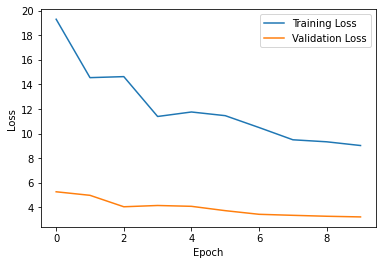

In [43]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def preprocess_data(image_path, labeled_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    
    # Preprocess labeled image (similar to what you did before)
    labeled_image = load_img(labeled_path, target_size=target_size)
    labeled_image = img_to_array(labeled_image)
    labeled_image = labeled_image / 255.0  # Normalize to [0, 1]
    
    return image, labeled_image

# Load and preprocess the data from CSV file
def load_data(csv_file_path):
    data_df = pd.read_csv(csv_file_path)
    images = []
    labeled_images = []
    for index, row in data_df.iterrows():
        image_path = row['ImagePath']
        labeled_path = row['LabelledImagePath']
        image, labeled_image = preprocess_data(image_path, labeled_path)
        images.append(image)
        labeled_images.append(labeled_image)

    return np.array(images), np.array(labeled_images)

# Build the CNN model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(np.prod(input_shape), activation='sigmoid'))  # Output layer for labeled image prediction
    model.add(Reshape(input_shape))  # Reshape output to match input image shape
    return model

# Function to read image file paths and labeled image file paths from CSV file
def read_data_from_csv(csv_file_path):
    data_df = pd.read_csv(csv_file_path)
    image_file_names = data_df['ImagePath'].tolist()
    labeled_file_names = data_df['LabelledImagePath'].tolist()
    return image_file_names, labeled_file_names

# Example usage:
csv_file_path = 'Noses.csv'
image_folder_path = 'images'
labeled_folder_path = 'labeled_images'

# Read image file paths and labeled image file paths from CSV file
image_file_names, labeled_file_names = read_data_from_csv(csv_file_path)

# Load and preprocess the data
images, labeled_images = load_data(csv_file_path)

print(images.shape, labeled_images.shape)
# Normalize image data to [0, 1]
images = images.astype('float32') / 255.0

# Split the data into training and validation sets
split_index = int(0.8 * len(images))
x_train, x_val = images[:split_index], images[split_index:]
y_train, y_val = labeled_images[:split_index], labeled_images[split_index:]

# Build the CNN model
input_shape = images[0].shape
print(input_shape)
print(labeled_images[0].shape)
model = build_model(input_shape)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))

# Train the model
batch_size = 32
epochs = 10
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

# Save the trained model
model.save("labeled_image_model.h5")

# Visualize training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [51]:
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

# Function to load and preprocess data
def load_and_preprocess_data(csv_file_path, image_folder):
    data_df = pd.read_csv(csv_file_path)
    images = []
    bounding_boxes = []
    for index, row in data_df.iterrows():
        image_path = image_folder + '/' + row['filename']
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
        images.append(image)

        coord = row['region_shape_attributes']
        # Convert string to dictionary
        coord = eval(coord)

        # Normalize bounding box coordinates to range [0, 1]
        x = coord['x'] / 224.0
        y = coord['y'] / 224.0
        width = coord['width'] / 224.0
        height = coord['height'] / 224.0
        bounding_box = [x, y, width, height]
        bounding_boxes.append(bounding_box)

    return np.array(images), np.array(bounding_boxes)

# Load and preprocess the data from CSV file
csv_file_path = 'noses/profile/bounding_boxes.csv'  # Replace with the path to your CSV file
image_folder = 'noses/profile'  # Replace with the path to the folder containing images
images, bounding_boxes = load_and_preprocess_data(csv_file_path, image_folder)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, bounding_boxes, test_size=0.2, random_state=42)

# Build the CNN model for bounding box regression
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='linear'))  # 4 output nodes for bounding box coordinates (x, y, width, height)

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

# Train the model
batch_size = 32
epochs = 10
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

# Save the trained model
model.save("bounding_box_regression_model.h5")


Train on 9 samples, validate on 3 samples
Epoch 1/10
9/9 [==============================] - 3s 368ms/sample - loss: 5716.8887 - val_loss: 29492512.0000
Epoch 2/10
9/9 [==============================] - 1s 74ms/sample - loss: 29190296.0000 - val_loss: 1634677.8750
Epoch 3/10
9/9 [==============================] - 1s 76ms/sample - loss: 1624375.5000 - val_loss: 207882.6719
Epoch 4/10
9/9 [==============================] - 1s 82ms/sample - loss: 206347.0625 - val_loss: 76769.7578
Epoch 5/10
9/9 [==============================] - 1s 80ms/sample - loss: 76269.2188 - val_loss: 39783.7539
Epoch 6/10
9/9 [==============================] - 1s 80ms/sample - loss: 40440.7031 - val_loss: 39004.3438
Epoch 7/10
9/9 [==============================] - 1s 84ms/sample - loss: 39922.0156 - val_loss: 10176.3936
Epoch 8/10
9/9 [==============================] - 1s 77ms/sample - loss: 10531.2842 - val_loss: 3865.5137
Epoch 9/10
9/9 [==============================] - 1s 74ms/sample - loss: 3711.8979 - val_lo

Eyes - 38/39
Head - 25-28
Background avg - 18-22
